# Modeling

### Imports

In [2]:
#Data Handling
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

#Stats
from scipy import stats
from scipy.stats import norm, skew

#Warnings
import warnings

#Modeling
import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
#There are some additional modeling imports below
#Specifically for the Neural Net

#Modeling with XGBoost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

### Data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

First I'm going to drop all properties with an above ground living area greater than 4000, as per both my analysis and the documentation of the data set.

In [4]:
index_drop = train[train["GrLivArea"] > 4000].index
train.drop(index = index_drop, inplace = True)
train.reset_index(drop = True, inplace = True)

Next I'm going to concatenate the training and test sets so that all feature engineering/dropping is applied to both sets. I'll also review and fill both sets NA values identically this way, guaranteeing that the two data sets have the same levels for all categorical features.

In [5]:
#Concatenating Test and Train for variable dropping/encoding/transforming etc.
train_SalePrice = train.loc[:,"SalePrice"]
train.drop(columns="SalePrice", inplace = True)

train["IsTrain"] = np.ones(shape = len(train))
test["IsTrain"] = np.zeros(shape = len(test))

test_id = test.loc[:,"Id"]

all_data = pd.concat([train, test]).reset_index(drop = True)
all_data.drop(columns = ["Id", "PoolArea", "PoolQC", "Fence", "MiscFeature", "MiscVal", "GarageYrBlt", "Alley", "Utilities"], inplace = True)

Now, based on the analysis done in the Main exploratory file, I'll be collapsing a few levels of interesting variables, as well as dropping  those variables which I found to have practically no relationship with the Sale Price (ie. both sale date variables) or which were found to be largely missing.

### Preprocessing

#### Filling Missing Values  
The majority of the missing values in the data set are due to the absence of a feature on the given property. This is specified in the data description file, and as such I've converted the NAN values to either 0's (in the numerical case) or to a categorical level of "None".  
Specified below are also a few variables which were filled with the mode of the respective feature. This was done as these features only experienced a very small number of missing values.

In [6]:
#treating missings using data description file info
#Filling with mean/median does not make sense for these entries
#LotFrontage
all_data.loc[:, "LotFrontage"] = all_data.loc[:, "LotFrontage"].fillna(0)

#Masonry
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)

#Basement:
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("None")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("None")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("None")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("None")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("None")
all_data.loc[:, "BsmtFinSF1"] = all_data.loc[:, "BsmtFinSF1"].fillna(0)
all_data.loc[:, "BsmtFinSF2"] = all_data.loc[:, "BsmtFinSF2"].fillna(0)
all_data.loc[:, "BsmtFullBath"] = all_data.loc[:, "BsmtFullBath"].fillna(0)
all_data.loc[:, "BsmtHalfBath"] = all_data.loc[:, "BsmtHalfBath"].fillna(0)
all_data.loc[:, "BsmtUnfSF"] = all_data.loc[:, "BsmtUnfSF"].fillna(0)
all_data.loc[:, "TotalBsmtSF"] = all_data.loc[:, "TotalBsmtSF"].fillna(0)


#Fireplace:
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("None")

#Garage:
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("None")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("None")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("None")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("None")
all_data.loc[:, "GarageCars"] = all_data.loc[:, "GarageCars"].fillna(0)
all_data.loc[:, "GarageArea"] = all_data.loc[:, "GarageArea"].fillna(0)


#Filling with Mode
#MSZoning
all_data.loc[:, "MSZoning"] = all_data.loc[:, "MSZoning"].fillna("RL")

#Exterior1st
all_data.loc[:, "Exterior1st"] = all_data.loc[:, "Exterior1st"].fillna("VinylSd")

#Exterior2nd
all_data.loc[:, "Exterior2nd"] = all_data.loc[:, "Exterior2nd"].fillna("VinylSd")

#Functional
all_data.loc[:, "Functional"] = all_data.loc[:, "Functional"].fillna("Typ")

#Electrical
all_data.loc[:, "Electrical"] = all_data.loc[:, "Electrical"].fillna("SBrkr")

#KitchenQual
all_data.loc[:, "KitchenQual"] = all_data.loc[:, "KitchenQual"].fillna("TA")

#SaleType
all_data.loc[:, "SaleType"] = all_data.loc[:, "SaleType"].fillna("WD")

Below I visualize the missing data in the data set one final to, just to double check that there are no eronious missing values that I have not caught.

Text(0.5, 1, 'Visualization of Missing Values in the All Data')

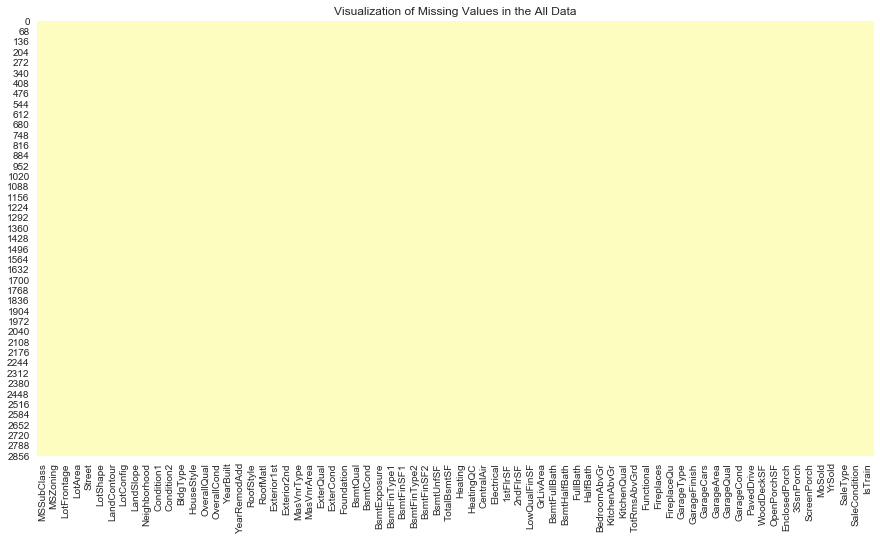

In [7]:
#visualizing the missing values in the training set
plt.figure(figsize=(15,8))
sns.heatmap(pd.isnull(all_data), cbar = False, cmap = "magma_r")
plt.title("Visualization of Missing Values in the All Data")

In [8]:
#Call the dataframe of observations with missing values
#If the dataframe is blank than I've successfully filled them all.
pd.set_option("display.max.columns", 999)
all_data[all_data.isnull().any(axis = 1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition,IsTrain


#### Encoding Numeric Variables which are Actually Categorical

In [9]:
all_data = all_data.replace(
    {"MSSubClass" : 
     {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 50 : "SC50",
     60 : "SC60", 70 : "SC70", 75 : "SC75", 80 : "SC80", 85 : "SC85",
     90 : "SC90", 120 : "SC120", 150: "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})
all_data["MSSubClass"] = all_data.MSSubClass.astype("object")

#### Order Encoding those Categorical Variables which should be Ordered  
Below I've encoded all the catergorical variables which were given levels respective to their quality with corresponding numeric values. Consistantly throughout the data set, low values will indicate poorer quality, while higher values will indicate better quality. Zero values show that the feature is absent.

In [10]:
all_data = all_data.replace(
    {"LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
    "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
    "ExterQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "ExterCond" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4}, #, "Ex" : 5}, There are no excellent condition basements in all the data
    "BsmtExposure" : {"None" : 0, "No" : 1, "Mn" : 2, "Av" : 3, "Gd" : 4},
    "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "CentralAir" : {"N" : 0, "Y" : 1},
    "Electrical" : {"Mix" : 1, "FuseP" : 1, "FuseF" : 2, "FuseA" : 3, "SBrkr" : 4},
    "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod" : 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
    "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
    "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "PavedDrive" : {"N" : 1, "P" : 2, "Y" : 3}})

In [11]:
cate_feats = all_data.dtypes[all_data.dtypes == "object"].index
for feat in cate_feats:
    all_data[feat] = all_data[feat].astype("category")

In [12]:
from sklearn.preprocessing import LabelEncoder
cate_feats = all_data.dtypes[all_data.dtypes == "category"].index

In [13]:
lbl = LabelEncoder()
for feat in cate_feats:
    lbl.fit(list(all_data[feat].values))
    all_data[feat] = lbl.transform(list(all_data[feat].values))

### Feature Engineering  
In the process of my feature engineering, I'll be preforming two seperate tasks.
+ Combining features which I believe show similar information
+ Correcting what skew I can in the numeric features  

#### Combining Features
I'll be creating 6 combined features, for each of the asspects of the properties where there are multiple quality or grading features. For example, I'll be creating an "OverallGrade" feature which combines the given "Overal Condition" grade and the "Overall Quality" grade. I'll be doing the same for the,
+ Exterior Features
+ Basement Features
+ Garage Features
+ All Grading Features

In [14]:
#Creating a Total Area Feature
all_data["TotSqFt"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
#Dropping all other square foot variables
#as they are all highly functionally linked
all_data.drop(columns=["GrLivArea", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF"], inplace = True)

#Creating Overall Grade of Property
all_data["OverallGrade"] = all_data["OverallCond"] + all_data["OverallQual"]

#Creating Exterior Grade
all_data["ExterGrade"] = all_data["ExterCond"] + all_data["ExterQual"]

#Creating Basement Grade
all_data["BsmtGrade"] = all_data["BsmtCond"] + all_data["BsmtQual"]

#Creating Total Basement Score
all_data["TotBsmtGrade"] = all_data["BsmtCond"] + all_data["BsmtQual"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"]

#Creating Garage Grade
all_data["GarageGrade"] = all_data["GarageCond"] + all_data["GarageQual"]

#Creating Total Property Score
all_data["TotalScore"] = all_data["OverallCond"] + all_data["OverallQual"] + all_data["ExterCond"] + all_data["ExterQual"] + all_data["BsmtCond"] + all_data["BsmtQual"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"] + all_data["LotShape"] + all_data["LandSlope"] + all_data["HeatingQC"] + all_data["CentralAir"] + all_data["Electrical"] + all_data["KitchenQual"] + all_data["Functional"] + all_data["FireplaceQu"] + all_data["GarageFinish"] + all_data["PavedDrive"]

#### Skewed Features
The majority of the purely numeric features appear to be skewed normal distributions. Having reviewed the effects of both the logistic transformation, and the Box Cox transformation to correct the skew, I've opted to use the Box Cox for the predictive features. At a later point in this notebook I'll be applying a log transformation exclusively to the response, the Sale Price, as this showed a better correction of the skew in the sale price.

In [16]:
#Transforming skewed numerical predictors with box cox
num_feats = []
for feat in all_data:
    if feat in cate_feats:
        pass
    else:
        num_feats.append(feat)

In [17]:
skewed_feats = all_data[num_feats].apply(lambda x: skew(x)).sort_values(ascending = False)
skewness = pd.DataFrame({"Skew" : skewed_feats})
skewness.head(10)

,Skew
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892
BsmtFinType2,3.149564
MasVnrArea,2.600697


In [18]:
from scipy.special import boxcox1p
skewness = skewness[abs(skewness["Skew"]) > 0.75]
skewed_feats = skewness.index
skewed_feats.shape

(30,)

In [19]:
#Box Cos Transform
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [20]:
#Log Transform
#for feat in skewed_feats:
#    all_data.loc[all_data[feat] == 0, feat] += 1
#    all_data[feat] = np.log(all_data[feat])

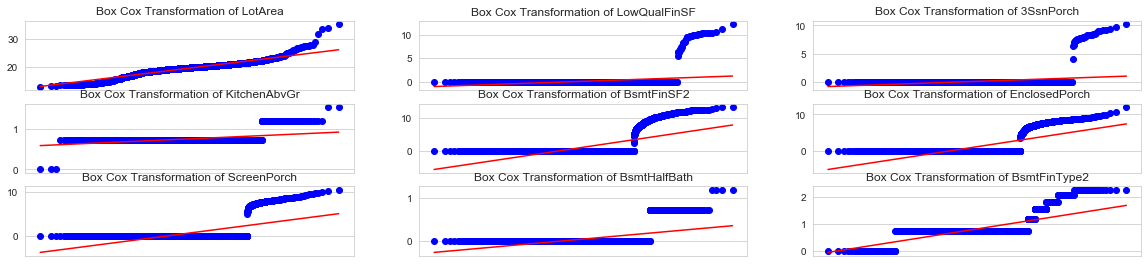

In [21]:
#Displaying Effect of Box Cox Transformation
fig = plt.figure(figsize = (20, 15))

for i, feat in enumerate(skewed_feats):
    if i < 9:
        ax = fig.add_subplot(10, 3, i+1)
        stats.probplot(all_data[feat], plot = plt)
        plt.title("Box Cox Transformation of {}".format(feat))
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.set_xticks([])

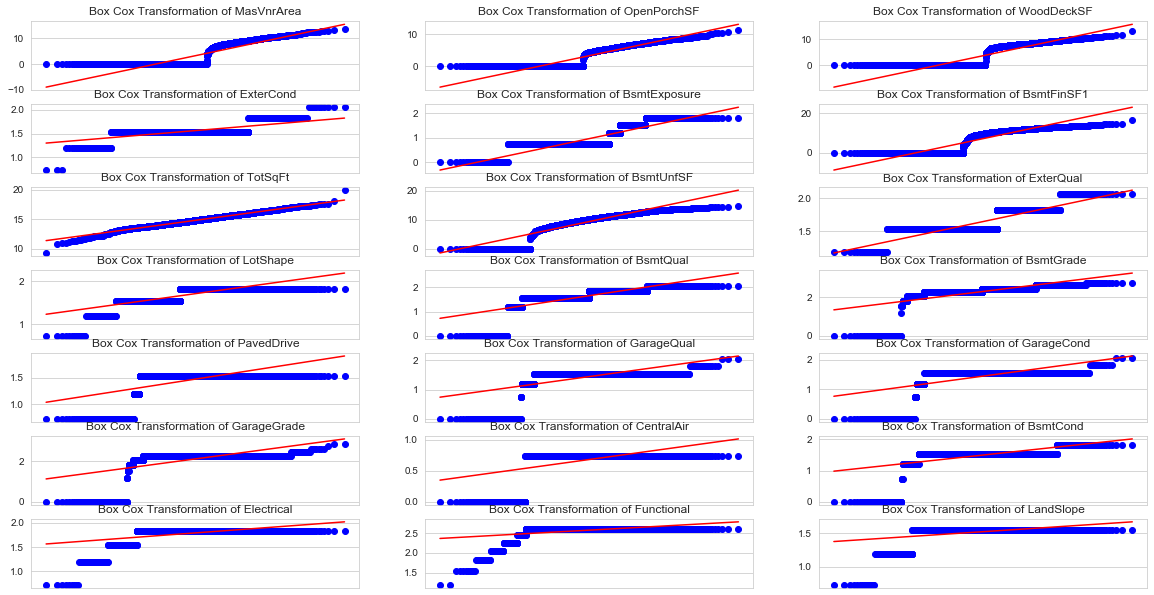

In [22]:
#Displaying Effect of Box Cox Transformation
fig = plt.figure(figsize = (20, 15))

for i, feat in enumerate(skewed_feats):
    if i >=9:
        ax = fig.add_subplot(10, 3, i+1)
        stats.probplot(all_data[feat], plot = plt)
        plt.title("Box Cox Transformation of {}".format(feat))
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.set_xticks([])

In [23]:
#Since all are now int this is not necessary
#all_data = pd.get_dummies(all_data, drop_first = True)

**Splitting Test and Train**  
Now, using the feature I created before merging the test and training sets, which is just a bollean indicating if the observation came from the test or training set, I'll split them again, so I can train my models exclusively on the traning set.

In [24]:
train = all_data.loc[all_data["IsTrain"] == 1, :]
test = all_data.loc[all_data["IsTrain"] == 0, :]

**Log Transformation of Sales Price**  
I'll now apply the log transformation to the SalePrice variable of the training set, which I split off before feature engineering.

In [25]:
#Log transform of SalePrice
y_train = np.log(train_SalePrice)

**Scaled Version of the Training Set**  
At certain points in my modeling I'll want to use and review different types of scaling for the training set, specifically for the neural net created at the end of this analysis. In the mojority of the base modeling I'll just be creating a pipeline which include whichever scaling method I want to use.

In [26]:
#Creating scaled versions of the training and test set
#Standard Scaling
scaler = StandardScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns= train.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns = test.columns)

#Robust Scaling
scaler = RobustScaler()
scaler.fit(train)
train_rob_scal = pd.DataFrame(scaler.transform(train), columns = train.columns)
test_rob_scaled = pd.DataFrame(scaler.transform(test), columns = test.columns)

#Normalizing
scaler = Normalizer()
scaler.fit(train)
train_norm = pd.DataFrame(scaler.transform(train), columns=train.columns)
test_norm = pd.DataFrame(scaler.transform(test), columns = test.columns)

### Keras Modeling


In [32]:
#Validation Function:
#Adding random shuffle to cross validation folds

def rand_shuf_cv(model, n_folds, train_values = train.values):
    kfolds = KFold(n_folds, shuffle=True, random_state = 84)
    rmse = np.sqrt(-cross_val_score(model, train_values, y_train, scoring = "neg_mean_squared_error", cv = kfolds))
    return(rmse)

In [33]:
#Dataframe to tune model
dtrain = train.copy()
dtrain["SalePrice"] = y_train
predictors = [x for x in dtrain.columns if x not in ["SalePrice"]]

### Keras Regression
For my neural network, I'm going to find a more parsimonius model. 

#### Feature Selection
I'll be using NUMBER OF METHODS to check the importance of the features in the data set. I'll be selecting the top 20 most important features. The first of the selection methods will be Recursive Feature Elimination, built using lasso regression. Since this will be built with Lasso, which is highly sensitive to outliers, I'll be using the training data which was robustly scaled - `train_rob_scal`

In [27]:
#Feature Extraction Methods
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

**RFE Feature Extraction**

In [29]:
estimator = Lasso()
rfe = RFE(estimator, 20)
fit = rfe.fit(train_rob_scal, y_train)

In [34]:
#Creating a dictionary to convert ranking of predictors
#from numbered to the feature names
#x_labels will provide the list of ordered important features
#Additionally, the first 20 in the x_labels list can be used 
#to slice the training set based on this algorithms selection
preds_dict = dict(zip(range(len(predictors)), predictors))
x_labels = []
for el in list(fit.ranking_):
    x_labels.append(preds_dict[el])


print("Selected Features: {} \n\n".format(train.columns[fit.support_]))
print("Feature Ranking: {}".format(x_labels[:20]))

Selected Features: Index(['GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'IsTrain', 'TotSqFt', 'OverallGrade',
       'ExterGrade', 'BsmtGrade', 'TotBsmtGrade', 'GarageGrade', 'TotalScore'],
      dtype='object') 


Feature Ranking: ['GarageCond', 'GarageQual', 'GarageArea', 'GarageCars', 'GarageFinish', 'GarageType', 'FireplaceQu', 'Fireplaces', 'Functional', 'TotRmsAbvGrd', 'KitchenQual', 'KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'FullBath', 'BsmtHalfBath', 'BsmtFullBath', 'LowQualFinSF', 'Electrical', 'CentralAir']


**Predictors Selected based on the Ensemble Methods**  
The predictors in the parsimonius predictors `(preds_pars)` below are selected based on the feature importance information found in the above ensemble methods, including the random forest, gradient boosting, and xgboost models.

In [36]:
preds_pars = ["TotSqFt", "OverallQual", "TotalScore", "GarageCars",
              "GarageFinish", "KitchenQual", "GarageCond", "YearRemodAdd",
              "GarageType", "MSZoning", "CentralAir", "FireplaceQu",
              "TotRmsAbvGrd", "LotArea", "GarageArea", "ExterQual", "FullBath"]
len(preds_pars)

17

#### Modeling with the Neural Net

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

Using TensorFlow backend.


**Lasso RFE Selected Features Model**

In [38]:
def BaseModel():
    #creating the keras model
    #Fully Connected Model
    model = Sequential()
    model.add(Dense(20, input_dim = 20, kernel_initializer = "normal", activation = "relu"))
    model.add(Dense(12, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mse"])
    return(model)

estimator = KerasRegressor(build_fn=BaseModel, epochs = 100, batch_size = 30, verbose = 0)

In [39]:
#Scoring for the more parsimonius training feature set
score = rand_shuf_cv(estimator, 5, train_rob_scal[x_labels[:20]])
score.mean()

0.19947860585061397

**Parsimonius Predictors Model**

In [40]:
def BaseModel():
    #creating the keras model
    #Fully Connected Model
    model = Sequential()
    model.add(Dense(17, input_dim = 17, kernel_initializer = "normal", activation = "relu"))
    model.add(Dense(12, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mse"])
    return(model)

estimator = KerasRegressor(build_fn=BaseModel, epochs = 100, batch_size = 40, verbose = 0)

In [41]:
#Scoring for the more parsimonius training feature set
score = rand_shuf_cv(estimator, 5, train_rob_scal[preds_pars])
score.mean()

0.1534756952065291

In [ ]:
#tuneing the parsimonius model
#tuneing epochs and batch size
param_grid = [{
    "epochs" : [90, 100, 110],
    "batch_size" : [30, 35, 40]
}]

#Preforming GridSearch
clf = GridSearchCV(estimator, param_grid = param_grid, 
                   cv = 5, scoring = "neg_mean_squared_error")
clf.fit(train_rob_scal[preds_pars], y_train)
clf.best_params_

In [ ]:
#Tuneing Optimizer
param_grid = [{
    "optimizer" : ["Nadam", "RMSprop", "SGD", "Adamax", "Adam", "Adagrad"]
}]

def BaseModel(optimizer = "adam"):
    #creating the keras model
    #Fully Connected Model
    model = Sequential()
    model.add(Dense(17, input_dim = 17, kernel_initializer = "normal", activation = "relu"))
    model.add(Dense(12, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer = optimizer, metrics = ["mse"])
    return(model)

estimator = KerasRegressor(build_fn=BaseModel, epochs = 100, batch_size = 35, verbose = 0)

#Preforming GridSearch
clf = GridSearchCV(estimator, param_grid = param_grid, 
                   cv = 5, scoring = "neg_mean_squared_error")
clf.fit(train_rob_scal[preds_pars], y_train)
clf.best_params_

In [ ]:
def BaseModel():
    #creating the keras model
    #Fully Connected Model
    model = Sequential()
    model.add(Dense(17, input_dim = 17, kernel_initializer = "normal", activation = "relu"))
    model.add(Dense(12, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer=optimizers.Adam(learning_rate = 0.005, amsgrad = True), metrics = ["mse"])
    return(model)

estimator = KerasRegressor(build_fn=BaseModel, epochs = 100, batch_size = 35, verbose = 0)

#Scoring for the more parsimonius training feature set
score = rand_shuf_cv(estimator, 5, train_rob_scal[preds_pars])
score.mean()

In [ ]:
#tuneing learning rate and momentum
param_grid = [{
    "learn_rate" : [0.001, 0.01, 0.1, 0.2, 0.3]
}]

#New Neural Net with updated Parameters
def BaseModel(learn_rate = 0.01):
    #creating the keras model
    #Fully Connected Model
    model = Sequential()
    model.add(Dense(17, input_dim = 17, kernel_initializer = "normal", activation = "relu"))
    model.add(Dense(12, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer=optimizers.Adam(learning_rate = learn_rate), metrics = ["mse"])
    return(model)

estimator = KerasRegressor(build_fn=BaseModel, epochs = 100, batch_size = 35, verbose = 0)

#Preforming GridSearch
clf = GridSearchCV(estimator, param_grid = param_grid, 
                   cv = 5, scoring = "neg_mean_squared_error")
clf.fit(train_rob_scal[preds_pars], y_train)
clf.best_params_

In [ ]:
#Fine tuning epochs and batch size
param_grid = [{
    "epochs" : [],
    "batch_size" : []
}]

#Preforming GridSearch
clf = GridSearchCV(estimator, param_grid = param_grid, 
                   cv = 5, scoring = "neg_mean_squared_error")
clf.fit(train_rob_scal[preds_pars], y_train)
clf.best_params_

In [ ]:
def BaseModel(learn_rate = 0.01):
    #creating the keras model
    #Fully Connected Model
    model = Sequential()
    model.add(Dense(17, input_dim = 17, kernel_initializer = "normal", activation = "relu"))
    model.add(Dense(12, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer=optimizers.Adam(learning_rate = 0.01), metrics = ["mse"])
    return(model)

estimator = KerasRegressor(build_fn=BaseModel, epochs = 100, batch_size = 35, verbose = 0)

In [ ]:
#scoring using full train feature set
score = rand_shuf_cv(estimator, 5, train_rob_scal[preds_pars])
score.mean()